In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd '/gdrive/My Drive/ADM/Colab/CNN'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/ADM/Colab/CNN


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# -*- coding: utf-8 -*-
"""
Created on Fri Mar  1 19:38:39 2019

@author: vasum
"""

# importing libraries and dependecies 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os
import pickle
from sklearn import metrics
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
#from keras import backend as K
from keras import optimizers
#K.set_image_dim_ordering('th')
# setting up a random seed for reproducibility
random_seed = 611
np.random.seed(random_seed)

# matplotlib inline
plt.style.use('ggplot')
# defining function for loading the dataset

PICKLE_DIR = './pickle_wisdom/'

#---------------------------------Dataset and Preprocessing---------------------------------------
plt.style.use('ggplot')
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))


def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90,step = 45):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for i in range(0, len(data) - window_size, step):
#    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][i:i+window_size]
        y = data["y-axis"][i:i+window_size]
        z = data["z-axis"][i:i+window_size]
#        if(len(dataset['timestamp'][i:i+window_size] == window_size):
        segments = np.vstack([segments,np.dstack([x,y,z])])
        labels = np.append(labels,stats.mode(data["activity"][i:i+window_size])[0][0])
#        print(".", end="")
        print(i,".", i+window_size)
        
    return segments, labels


def show_confusion_matrix(validations, predictions,LABELS):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    




def window_testing(win):
    # Segmenting the signal in overlapping windows of 90 samples with 50% overlap
    segments, labels = segment_signal(dataset,win,int(win/2)) 
    
    
    print('For window size, ',win)
    
    # Writing toJson for later use.
    # =============================================================================
    #np.save("segments", segments)
    #np.save("labels", labels)
    ##
    #segments = np.load("segments.npy")
    #labels = np.load("labels.npy")
    # =============================================================================
    
    
    # Categorically defining the classes of the activities
    labels = np.asarray(pd.get_dummies(labels),dtype = np.int8)
    
    # Parameters for the input and network layers
    # we are treating each segmeent or 2D Matrix (90 x 3)
    numOfRows = segments.shape[1]
    numOfColumns = segments.shape[2]
    numChannels = 1
    numFilters = 128 # number of filters in Conv2D layer
    
    # Size of the Conv2D layer
    kernalSize1 = 2
    poolingWindowSz = 2
    numNueronsFCL1 = 128
    numNueronsFCL2 = 128
    trainSplitRatio = 0.8
    Epochs = 50
    batchSize = 400
    numClasses = labels.shape[1]
    dropOutRatio = 0.2
    
    
    
    
    #-----------------------------Ceating The CNN Model-------------------------------------------
    
    reshapedSegments = segments.reshape(segments.shape[0], numOfRows, numOfColumns,1)
    # splitting in training and testing data
    trainSplit = np.random.rand(len(segments)) < trainSplitRatio
    trainX = reshapedSegments[trainSplit]
    testX = reshapedSegments[~trainSplit]
    trainX = np.nan_to_num(trainX)
    testX = np.nan_to_num(testX)
    trainY = labels[trainSplit]
    testY = labels[~trainSplit]
    
    #trainY = np.asarray(pd.get_dummies(labels),dtype = np.int8)
    #testY = np.asarray(pd.get_dummies(labels),dtype = np.int8)

    model = cnnModel(numChannels,numFilters,kernalSize1,poolingWindowSz,numNueronsFCL1,numNueronsFCL2,trainSplitRatio,Epochs,batchSize,numClasses,dropOutRatio,numOfColumns,numOfRows)

    model.summary()
    
    callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{val_acc:.2f}-{acc:.2f}-{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=2)
    ]
    
    adam = optimizers.Adam(lr = 0.01, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    history = model.fit(trainX,trainY, validation_split=1-trainSplitRatio,epochs=10,batch_size=batchSize,verbose=1,
                          callbacks=callbacks_list)
    
    #model = load_model('model.h5')
    
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

    score = model.evaluate(testX,testY,verbose=2)
    print('Baseline Error: %.2f%%' %(100-score[1]*100))
    
    # Print confusion matrix for training data
    y_pred_train = model.predict(testX)
    
    # Take the class with the highest probability from the train predictions
    max_y_pred_train = np.argmax(y_pred_train, axis=1)
    
    # getting the class predicted and class in ground truth for creation of confusion matrix
    predictedClass = np.zeros((y_pred_train.shape[0]))
    groundTruthClass = np.zeros((testY.shape[0]))
    for instance in range (testY.shape[0]):
        predictedClass[instance] = np.argmax(y_pred_train[instance,:])
        groundTruthClass[instance] = np.argmax(testY[instance,:])
    
    # Visualizing the result
    
    LABELS = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
    
    show_confusion_matrix(groundTruthClass, predictedClass,LABELS)
    print(classification_report(groundTruthClass, predictedClass))
    
    #model.save('model.h5')
    
    dump_path = PICKLE_DIR + str(win) + "/"
    if not os.path.exists(dump_path):
        os.makedirs(dump_path)
    
    print("Dumping Performance records ..")
    pickle.dump(testX, open(dump_path + "/testX.p", "wb"))
    pickle.dump(y_pred_train, open(dump_path + "/y_pred_train.p", "wb"))
    pickle.dump(groundTruthClass, open(dump_path + "/groundTruthClass.p", "wb"))
    pickle.dump(predictedClass, open(dump_path + "/predictedClass.p", "wb"))
    
    pickle.dump(segments, open(dump_path + "/segments.p", "wb"))
    pickle.dump(labels, open(dump_path + "/labels.p", "wb"))
    
    
    print("\n-------------------------------------------------------------------------")
    

def cnnModel(numChannels,numFilters,kernalSize1,poolingWindowSz,numNueronsFCL1,numNueronsFCL2,trainSplitRatio,Epochs,batchSize,numClasses,dropOutRatio,numOfColumns,numOfRows):
    
    model = Sequential()
    # First convolutionial layer with 32 filters and 5 by 5 kernal size.
    model.add(Conv2D(numFilters, (kernalSize1,kernalSize1),input_shape=(numOfRows, numOfColumns, 1),activation='relu'))
    # Maxpooling layer
    model.add(MaxPooling2D(pool_size=(poolingWindowSz,poolingWindowSz),padding='valid'))
    # Dropout layer for the regularization and avoiding over fitting
    model.add(Dropout(dropOutRatio))
    # Fattening the output in order to apply the fully connected layer
    model.add(Flatten())
    # First fully connected layer with 256 outputs
    model.add(Dense(numNueronsFCL1, activation='relu'))
    # Second fully connected layer 128 outputs
    model.add(Dense(numNueronsFCL2, activation='relu'))
    # Softmax layer for the classification
    model.add(Dense(numClasses, activation='softmax'))
    
    return model


    






In [3]:
#------------------------------reading the data------------------------------------------
    
%cd '/gdrive/My Drive/ADM/Colab/LSTM'
  
dataset = pd.read_csv('WISDM.csv')

%cd '/gdrive/My Drive/ADM/Colab/CNN'

dataset = dataset.rename(columns={"time": "timestamp", "la_x": "x-axis", "la_y": "y-axis", "la_z": "z-axis"})


/gdrive/My Drive/ADM/Colab/LSTM
/gdrive/My Drive/ADM/Colab/CNN


In [0]:
dataset.dropna(axis=0, how='any', inplace= True)
# =============================================================================
# dataset = dataset[dataset.activity != 'Jogging']
# dataset = dataset[dataset.activity != 'Standing']
# dataset = dataset[dataset.activity != 'Walking']
# =============================================================================

#------------------------Normalize features for training data set (values between 0 and 1)-----------------------
# This must also be done to testing set later
pd.options.mode.chained_assignment = None  # default='warn'
dataset['x-axis'] = dataset['x-axis'] / dataset['x-axis'].max()
dataset['y-axis'] = dataset['y-axis'] / dataset['y-axis'].max()
dataset['z-axis'] = dataset['z-axis'] / dataset['z-axis'].max()

# Plotting a subset of the data to visualize
# for activity in np.unique(dataset["activity"]):
#     subset = dataset[dataset["activity"] == activity][:180]
#     plot_activity(activity,subset)

0 . 50
25 . 75
50 . 100
75 . 125
100 . 150
125 . 175
150 . 200
175 . 225
200 . 250
225 . 275
250 . 300
275 . 325
300 . 350
325 . 375
350 . 400
375 . 425
400 . 450
425 . 475
450 . 500
475 . 525
500 . 550
525 . 575
550 . 600
575 . 625
600 . 650
625 . 675
650 . 700
675 . 725
700 . 750
725 . 775
750 . 800
775 . 825
800 . 850
825 . 875
850 . 900
875 . 925
900 . 950
925 . 975
950 . 1000
975 . 1025
1000 . 1050
1025 . 1075
1050 . 1100
1075 . 1125
1100 . 1150
1125 . 1175
1150 . 1200
1175 . 1225
1200 . 1250
1225 . 1275
1250 . 1300
1275 . 1325
1300 . 1350
1325 . 1375
1350 . 1400
1375 . 1425
1400 . 1450
1425 . 1475
1450 . 1500
1475 . 1525
1500 . 1550
1525 . 1575
1550 . 1600
1575 . 1625
1600 . 1650
1625 . 1675
1650 . 1700
1675 . 1725
1700 . 1750
1725 . 1775
1750 . 1800
1775 . 1825
1800 . 1850
1825 . 1875
1850 . 1900
1875 . 1925
1900 . 1950
1925 . 1975
1950 . 2000
1975 . 2025
2000 . 2050
2025 . 2075
2050 . 2100
2075 . 2125
2100 . 2150
2125 . 2175
2150 . 2200
2175 . 2225
2200 . 2250
2225 . 2275
2250 

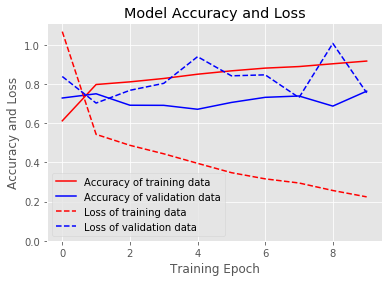

Baseline Error: 12.99%


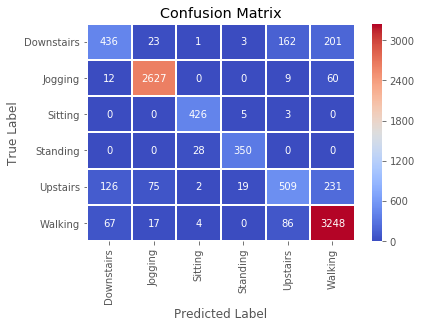

              precision    recall  f1-score   support

         0.0       0.68      0.53      0.59       826
         1.0       0.96      0.97      0.96      2708
         2.0       0.92      0.98      0.95       434
         3.0       0.93      0.93      0.93       378
         4.0       0.66      0.53      0.59       962
         5.0       0.87      0.95      0.91      3422

    accuracy                           0.87      8730
   macro avg       0.84      0.81      0.82      8730
weighted avg       0.86      0.87      0.86      8730

Dumping Performance records ..

-------------------------------------------------------------------------
0 . 80
40 . 120
80 . 160
120 . 200
160 . 240
200 . 280
240 . 320
280 . 360
320 . 400
360 . 440
400 . 480
440 . 520
480 . 560
520 . 600
560 . 640
600 . 680
640 . 720
680 . 760
720 . 800
760 . 840
800 . 880
840 . 920
880 . 960
920 . 1000
960 . 1040
1000 . 1080
1040 . 1120
1080 . 1160
1120 . 1200
1160 . 1240
1200 . 1280
1240 . 1320
1280 . 1360
1320 . 1

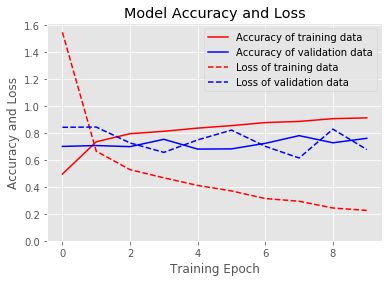

Baseline Error: 13.33%


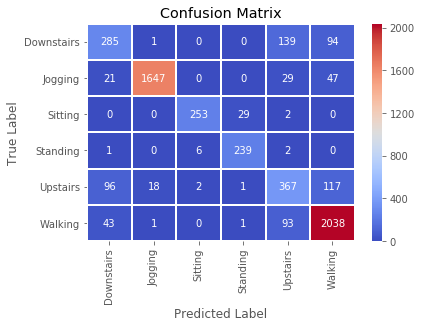

              precision    recall  f1-score   support

         0.0       0.64      0.55      0.59       519
         1.0       0.99      0.94      0.97      1744
         2.0       0.97      0.89      0.93       284
         3.0       0.89      0.96      0.92       248
         4.0       0.58      0.61      0.60       601
         5.0       0.89      0.94      0.91      2176

    accuracy                           0.87      5572
   macro avg       0.82      0.82      0.82      5572
weighted avg       0.87      0.87      0.87      5572

Dumping Performance records ..

-------------------------------------------------------------------------
0 . 120
60 . 180
120 . 240
180 . 300
240 . 360
300 . 420
360 . 480
420 . 540
480 . 600
540 . 660
600 . 720
660 . 780
720 . 840
780 . 900
840 . 960
900 . 1020
960 . 1080
1020 . 1140
1080 . 1200
1140 . 1260
1200 . 1320
1260 . 1380
1320 . 1440
1380 . 1500
1440 . 1560
1500 . 1620
1560 . 1680
1620 . 1740
1680 . 1800
1740 . 1860
1800 . 1920
1860 . 1980
19

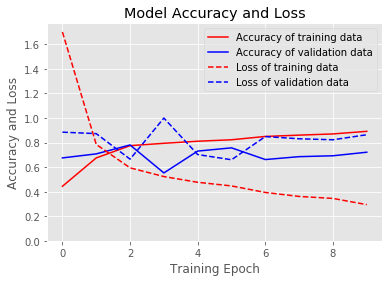

Baseline Error: 18.31%


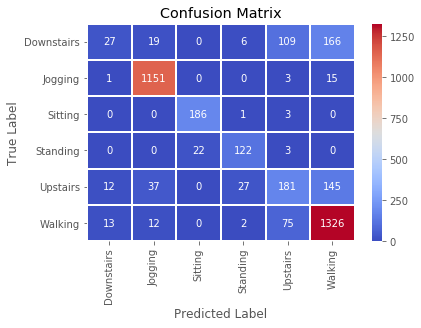

              precision    recall  f1-score   support

         0.0       0.51      0.08      0.14       327
         1.0       0.94      0.98      0.96      1170
         2.0       0.89      0.98      0.93       190
         3.0       0.77      0.83      0.80       147
         4.0       0.48      0.45      0.47       402
         5.0       0.80      0.93      0.86      1428

    accuracy                           0.82      3664
   macro avg       0.73      0.71      0.69      3664
weighted avg       0.79      0.82      0.79      3664

Dumping Performance records ..

-------------------------------------------------------------------------
0 . 160
80 . 240
160 . 320
240 . 400
320 . 480
400 . 560
480 . 640
560 . 720
640 . 800
720 . 880
800 . 960
880 . 1040
960 . 1120
1040 . 1200
1120 . 1280
1200 . 1360
1280 . 1440
1360 . 1520
1440 . 1600
1520 . 1680
1600 . 1760
1680 . 1840
1760 . 1920
1840 . 2000
1920 . 2080
2000 . 2160
2080 . 2240
2160 . 2320
2240 . 2400
2320 . 2480
2400 . 2560
2480 .

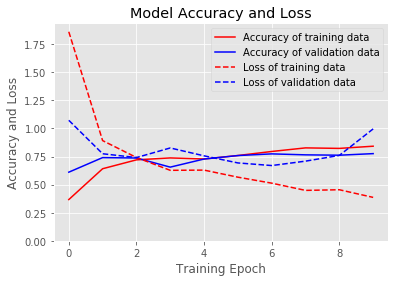

Baseline Error: 21.88%


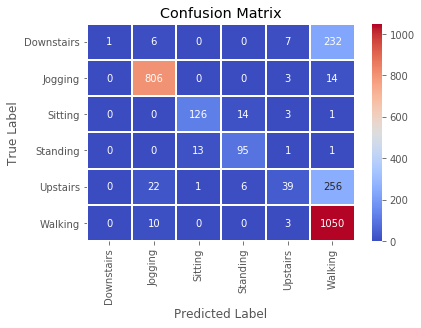

              precision    recall  f1-score   support

         0.0       1.00      0.00      0.01       246
         1.0       0.95      0.98      0.97       823
         2.0       0.90      0.88      0.89       144
         3.0       0.83      0.86      0.84       110
         4.0       0.70      0.12      0.21       324
         5.0       0.68      0.99      0.80      1063

    accuracy                           0.78      2710
   macro avg       0.84      0.64      0.62      2710
weighted avg       0.81      0.78      0.72      2710

Dumping Performance records ..

-------------------------------------------------------------------------
0 . 200
100 . 300
200 . 400
300 . 500
400 . 600
500 . 700
600 . 800
700 . 900
800 . 1000
900 . 1100
1000 . 1200
1100 . 1300
1200 . 1400
1300 . 1500
1400 . 1600
1500 . 1700
1600 . 1800
1700 . 1900
1800 . 2000
1900 . 2100
2000 . 2200
2100 . 2300
2200 . 2400
2300 . 2500
2400 . 2600
2500 . 2700
2600 . 2800
2700 . 2900
2800 . 3000
2900 . 3100
3000 . 3200

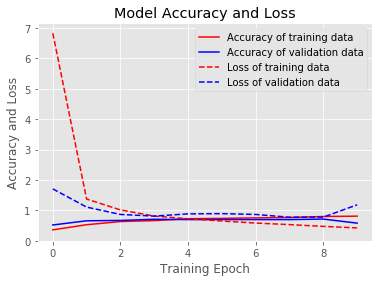

Baseline Error: 26.19%


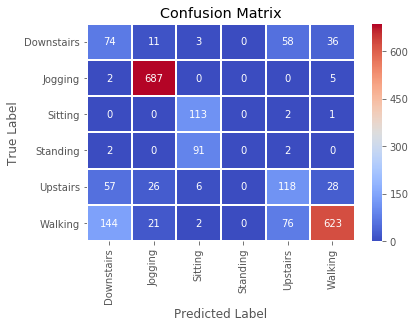

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.27      0.41      0.32       182
         1.0       0.92      0.99      0.95       694
         2.0       0.53      0.97      0.68       116
         3.0       0.00      0.00      0.00        95
         4.0       0.46      0.50      0.48       235
         5.0       0.90      0.72      0.80       866

    accuracy                           0.74      2188
   macro avg       0.51      0.60      0.54      2188
weighted avg       0.75      0.74      0.73      2188

Dumping Performance records ..

-------------------------------------------------------------------------


In [7]:
window_sizes =  [50, 80, 120, 160, 200]    

    
for win in window_sizes:
    window_testing(win)